# Import Statements

In [2]:
import numpy as np
import pandas as pd
from matplotlib import image
import matplotlib.pyplot as plt
import os
import sys
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Image processing and defining test train datasets

## Image extractions

In the below class :<br>
Initializes an empty list data.<br>
Iterates through each label (subdirectory) inside path.<br>
Reads each image file within the label’s subdirectory.<br>
Flattens the image into a 1D array and appends it to data, along with its corresponding label.<br>
Creates column names for the DataFrame (pixel1 to pixel784 for a 28x28 image and label for the class).<br>

In [3]:
def images(path):
    data = []
    
    for label in os.listdir(path):
        label_path = os.path.join(path, label)
        for img in os.listdir(label_path):
            img_data = image.imread(os.path.join(label_path, img)).flatten()
            data.append([*img_data, label])
    
    column_names = [f'pixel{i}' for i in range(1, 28 * 28 + 1)] + ['label']
    return pd.DataFrame(data, columns=column_names)

## Defining training and testing sets

In [4]:
train_set = images("Train")
test_set = images("Test")

train_set.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.0,0.0,Jane
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.0,0.0,Jane
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.0,0.0,Jane
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.0,0.0,Jane
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.0,0.0,Jane


In [5]:
X_train = train_set.drop(columns='label')
y_train = train_set['label']

X_test = test_set.drop(columns='label')
y_test= test_set['label']

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_train,y_train,sep = "\n")

[[0.         0.         0.         ... 0.00784314 0.         0.        ]
 [0.         0.         0.         ... 0.00784314 0.         0.        ]
 [0.         0.         0.         ... 0.00784314 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00784314 0.         0.        ]
 [0.         0.         0.         ... 0.00784314 0.         0.        ]
 [0.         0.         0.         ... 0.00784314 0.         0.        ]]
['Jane' 'Jane' 'Jane' ... 'Jade' 'Jade' 'Jade']


## One hot encoding

Did one hot encoding using sklearn library
Hence Changed the labels to numeric values

In [6]:
hot_obj = OneHotEncoder(sparse_output=False)
Y_train = hot_obj.fit_transform(y_train.reshape(-1, 1))
Y_test = hot_obj.transform(y_test.reshape(-1, 1))

Y_train

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

# Defining all the needy functions

## RelU


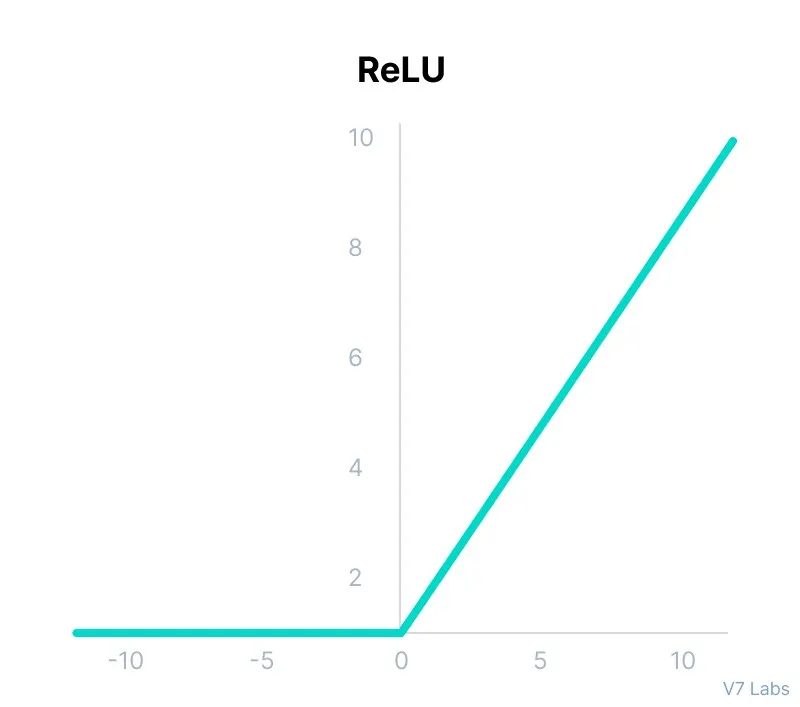

In [7]:
def relu(X, derivative=False):
    if derivative:
        return np.where(X > 0, 1, 0)
    return np.maximum(0, X)

## SoftMax

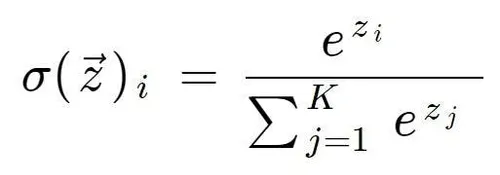

In [8]:
def softmax(X):
    X = np.asarray(X, dtype=np.float64)
    X_max = np.max(X, axis=-1, keepdims=True)
    e_X = np.exp(X - X_max)
    return e_X / np.sum(e_X, axis=-1, keepdims=True)

## Cross-Entropy loss

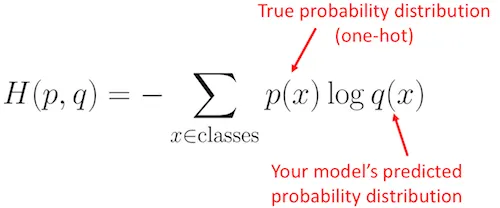

In [9]:
def cross_entropy_loss(y_true, y_pred, derivative=False):
    if derivative:
        return y_pred - y_true
    else:
        m = y_true.shape[0]
        return -np.sum(y_true * np.log(y_pred + 1e-15))

# Layering class

## Forward 
Computes linear transformation while using relU , softmax and Cross Entropy Lossing

In [10]:
class Layer:
    def __init__(self, input_size, output_size, atype):
        self.weights = np.random.randn(input_size, output_size) * 0.1
        self.bias = np.zeros((1, output_size))
        self.atype = atype

    def forward(self, input_data):
        self.input_data = input_data
        self.predictions = np.dot(input_data, self.weights) + self.bias
        if self.atype == 'relu':
            self.apreds = relu(self.predictions)
        elif self.atype == 'softmax':
            self.apreds = softmax(self.predictions)
        return self.apreds

    def backward(self, dA, alpha):
        if self.atype == 'relu':
            dZ = dA * relu(self.predictions, derivative=True)
        elif self.atype == 'softmax':
            dZ = dA
        
        m = self.input_data.shape[0]
        dW = np.dot(self.input_data.T, dZ) / m
        db = np.sum(dZ, axis=0, keepdims=True) / m
        
        self.weights -= alpha * dW
        self.bias -= alpha * db
        
        dA_prev = np.dot(dZ, self.weights.T)
        return dA_prev


# Neural Network IMPlemtationnnnnnn

## Main Class

In [11]:
class NeuralNetwork:
    def __init__(self, layer_sizes, atype):
        self.layers = []
        for i in range(1, len(layer_sizes)):
            activator = 'relu' if i < len(layer_sizes) - 1 else 'softmax'
            self.layers.append(Layer(layer_sizes[i-1], layer_sizes[i], activator))

    def forward(self, X):
        self.cache = []
        activation = X
        for layer in self.layers:
            activation = layer.forward(activation)
            self.cache.append(activation)
        return activation

    def backward(self, X, y_true, alpha):
        dA = cross_entropy_loss(y_true, self.cache[-1], derivative=True)
        for layer in reversed(self.layers):
            dA = layer.backward(dA, alpha)

    def train(self, X, y, epochs, initial_alpha, decay_rate=0.0001):
        loading_string = '⬛' * 20
        loading_list = list(loading_string)
        for epoch in range(epochs):
            alpha = initial_alpha / (1 + decay_rate * epoch)
            predictions = self.forward(X)
            loss = cross_entropy_loss(y, predictions)
            losses.append(loss)
            self.backward(X, y, alpha)
            if epoch % 200 == 0:
                loading_list[epoch//200] = '⬜'  # Change dot to 'X'
                sys.stdout.write('\r' + ''.join(loading_list))
                sys.stdout.flush()
    
    def predict(self, values):
        return self.forward(values)

## Training .. . 

In [12]:
losses = []
layer_sizes = [28*28, 30, 5] 
atype = 'relu'  
nut = NeuralNetwork(layer_sizes, atype)
epochs = 4000
initial_alpha = 0.1111
nut.train(X_train, Y_train, epochs, initial_alpha)
print("Done")

⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜Done


# Plotting and Testing

## Epoch Vs Loss

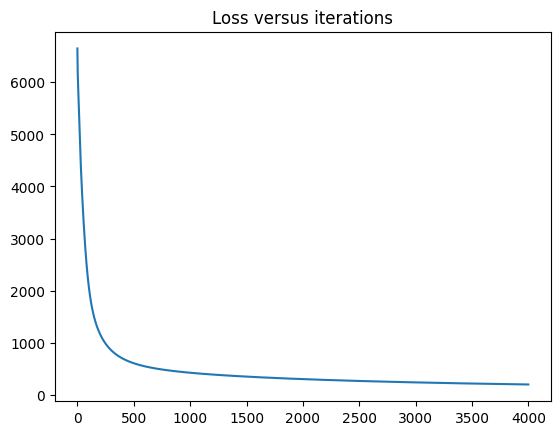

In [13]:
plt.plot(range(0, epochs), losses)
plt.title("Loss versus iterations")
plt.show()

## Tetsing ... .

In [14]:
Y_pred = nut.predict(X_test)
Y_pred_labels = np.argmax(Y_pred, axis=1)
Y_true_labels = np.argmax(Y_test, axis=1)

## Confusion matrix

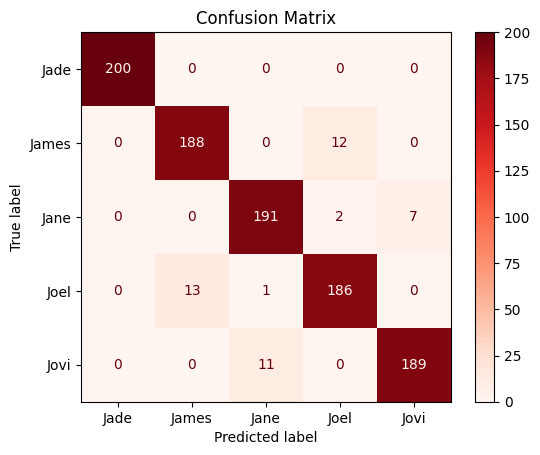

In [15]:
conf_matrix = confusion_matrix(Y_true_labels, Y_pred_labels)
display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=hot_obj.categories_[0])
display.plot(cmap=plt.cm.Reds)
plt.title("Confusion Matrix")
plt.show()

## Classification report

In [16]:
accuracy = accuracy_score(Y_true_labels, Y_pred_labels)
f1 = f1_score(Y_true_labels, Y_pred_labels, average=None)
recall = recall_score(Y_true_labels, Y_pred_labels, average=None)
precision = precision_score(Y_true_labels, Y_pred_labels, average=None)

print("Accuracy =", accuracy)
print("F1 Score =", f1)
print("Recall Score =", recall)
print("Precision Score =", precision)

Accuracy = 0.954
F1 Score = [1.         0.93765586 0.94789082 0.93       0.95454545]
Recall Score = [1.    0.94  0.955 0.93  0.945]
Precision Score = [1.         0.93532338 0.9408867  0.93       0.96428571]
